# Potential Suicide Detection based on Text

## Initializations

In [7]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

In [8]:
# Reading the dataset
df = pd.read_csv('./dataset/processed.csv')

In [9]:
df.head()

,text,class
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird dont get affected compliment coming some...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im cry hard,suicide
4,im losthello name adam 16 ive struggling year ...,suicide


In [10]:
df.shape

(232074, 2)

In [11]:
# Check class distribution
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

## Models Training

In [12]:
X, y = df['text'], df['class']

In [13]:
X

0         ex wife threatening suiciderecently left wife ...
1         weird dont get affected compliment coming some...
2         finally 2020 almost never hear 2020 bad year e...
3                            need helpjust help im cry hard
4         im losthello name adam 16 ive struggling year ...
                                ...                        
232069    dont like rock going get anything go httpsmusi...
232070    tell many friend lonely everything deprived pr...
232071    pee probably taste like salty tea someone dran...
232072    usual stuff find hereim posting sympathy pity ...
232073    still havent beaten first bos hollow knight iv...
Name: text, Length: 232074, dtype: object

In [14]:
y

0             suicide
1         non-suicide
2         non-suicide
3             suicide
4             suicide
             ...     
232069    non-suicide
232070    non-suicide
232071    non-suicide
232072        suicide
232073    non-suicide
Name: class, Length: 232074, dtype: object

### TF-IDF Vectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf.fit_transform(X.values.astype('U')).toarray()

In [16]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
# Save the TfidfVectorizer
with open('./model/tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf, f)

### Data Preparation

In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = 42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((185659, 5000), (46415, 5000), (185659,), (46415,))

### LGBM Classifier

In [20]:
# LGBGM Classifier
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [21]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Visualize confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Reds');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
    plt.title(all_sample_title, size = 15);
    plt.savefig('./public/confusion_matrix.png')
    plt.show()

              precision    recall  f1-score   support

 non-suicide       0.91      0.93      0.92     23208
     suicide       0.93      0.90      0.91     23207

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



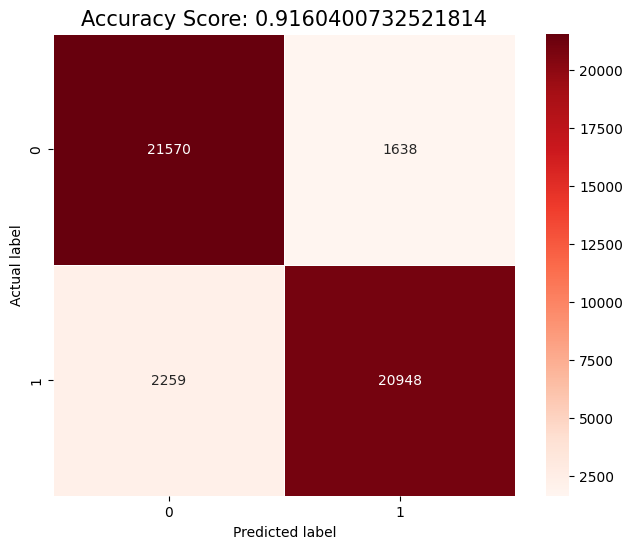

In [22]:
evaluate(lgbm)

In [23]:
# Save the model
with open('./model/lgbm.pickle', 'wb') as f:
    pickle.dump(lgbm, f)

## Testing

In [24]:
# Load the model
with open('./model/lgbm.pickle', 'rb') as f:
    model = pickle.load(f)

# Load the TfidfVectorizer
with open('./model/tfidf.pickle', 'rb') as f:
    tfidf = pickle.load(f)

# Load neccessary nltk packages
import nltk
stop_words = nltk.corpus.stopwords.words('english') #remove stopwords
lemmer = nltk.stem.WordNetLemmatizer() #lemmatization

In [25]:

def preprocess_text(text):
    text = text.lower() #convert to lower case 
    text = text.replace(r'[^\w\s]+', '') #remove punctuations
    text = [word for word in text.split() if word not in (stop_words)] #tokenize the sentence
    text = ' '.join([lemmer.lemmatize(i) for i in text])
    inputToModel = tfidf.transform([text]).toarray() #transform to vector form
    return inputToModel

In [26]:
# Test the model
def predict(text):
    text = preprocess_text(text)
    return model.predict(text)[0]

### Suicidal

In [27]:
texts = [
    "I am just tired of this life, I don't want to live anymore",
    "tired of everything, can we just end this?",
    "Can my life be any worse?, I dont think so",
    "Why is life so unfair to me?, I just want to die",
]

for text in texts:
    print(predict(text))

suicide
suicide
suicide
suicide


### Non-Suicidal

In [28]:
texts = [
    "I am so happy today",
    "tired of today, I'll just sleep",
    "Sadness is a part of life",
    "Today may be the worst day of my life",
]

for text in texts:
    print(predict(text))

non-suicide
non-suicide
non-suicide
non-suicide
